<div style="border:2px solid purple; padding:10px; background-color:#ffe6f0; border-radius:8px; color:black;">


# **SMS Spam Detection**

<div style="border:2px solid #3399ff; padding:10px; background-color:#e6f3ff; border-radius:8px; color:black;">

#### **Import the libaries**

In [2]:
import pandas as pd
import numpy as np 
import nltk 

<div style="border:2px solid #3399ff; padding:10px; background-color:#e6f3ff; border-radius:8px; color:black;">

#### **Loading the Dataset**

The dataset used in this project is the SMS Spam Collection Dataset, which contains SMS messages labeled as either ham (legitimate) or spam.

In [3]:
df = pd.read_csv(r"spam.csv", encoding = 'latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

<div style="border:2px solid #3399ff; padding:10px; background-color:#e6f3ff; border-radius:8px; color:black;">


#### **Initial Exploration of Data**

The dataset initially had 5 columns:

* v1 → contained the labels (ham / spam).

* v2 → contained the SMS text message.

* Unnamed: 2, Unnamed: 3, Unnamed: 4 → extra columns with very few non-null values (irrelevant to analysis).

<div style="border:2px solid green; padding:10px; background-color:#e6ffe6; border-radius:8px; color:black;">

## **Data Cleaning**

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


<div style="border:2px solid green; padding:10px; background-color:#e6ffe6; border-radius:8px; color:black;">

Since the last three columns were unnecessary and sparsely populated, I dropped them using drop().
I also renamed the remaining two columns for better readability:

* v1 → label

* v2 → text

In [6]:
df = df.drop(columns = ['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis = 1)

In [7]:
df = df.rename(columns = {"v1" : "label","v2":"text"})

In [8]:
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
df.shape

(5572, 2)

In [10]:
x_prev=df.shape[0]

In [11]:
# Missing Values
df.isnull().sum()

label    0
text     0
dtype: int64

<div style="border:2px solid green; padding:10px; background-color:#e6ffe6; border-radius:8px; color:black;">

Since machine learning models work better with numerical data, I converted these text labels into numeric form using **Label Encoding**:  

- ham → 0  
- spam → 1

In [12]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [13]:
df['label'] = encoder.fit_transform(df['label'])

In [14]:
df.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [15]:
# Duplicate Values
df.duplicated().sum()

np.int64(403)

<div style="border:2px solid green; padding:10px; background-color:#e6ffe6; border-radius:8px; color:black;">

On inspection, the dataset contained duplicate messages that could bias the model training.

To ensure clean and reliable data, I removed duplicate rows while keeping the first occurrence.

In [16]:
# Remove duplicate values

df = df.drop_duplicates(keep = 'first')

In [17]:
df.duplicated().sum()

np.int64(0)

In [18]:
df.shape

(5169, 2)

In [19]:
x_now=df.shape[0]

In [20]:
x_prev - x_now

403

<div style="border:2px solid yellow; padding:10px; background-color:#ffffcc; border-radius:8px; color:black;">

## **Exploratory Data Analysis**

<div style="border:2px solid yellow; padding:10px; background-color:#ffffcc; border-radius:8px; color:black;">

### **Distribution of Labels**  
To understand the balance of the dataset, I counted the number of **ham** and **spam** messages.

In [21]:
df['label'].value_counts()

label
0    4516
1     653
Name: count, dtype: int64

<div style="border:2px solid yellow; padding:10px; background-color:#ffffcc; border-radius:8px; color:black;">


This shows the dataset is imbalanced, with significantly more ham messages than spam.

To visualize this, I plotted a pie chart:

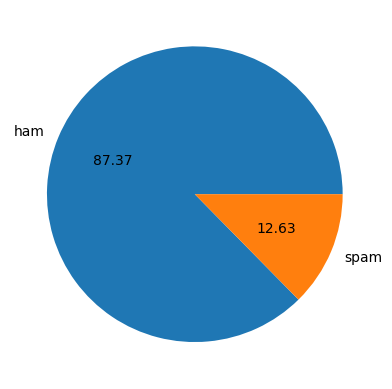

In [22]:
import matplotlib.pyplot as plt

plt.pie(df['label'].value_counts(),labels= ['ham','spam'], autopct = "%0.2f")
plt.show()

In [23]:
import nltk
nltk.download('punkt_tab')  
nltk.download('punkt')      


[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\sowmy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sowmy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

<div style="border:2px solid yellow; padding:10px; background-color:#ffffcc; border-radius:8px; color:black;">

### **Feature Engineering for Text Statistics**

I created new columns to extract some basic statistics from each SMS message:

* num_characters → total number of characters in the message.

* num_words → total number of words in the message.

* num_sentences → total number of sentences in the message.

In [24]:
df['num_characters'] = df['text'].apply(len)

In [25]:
df.head()

,label,text,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [26]:
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))

In [27]:
df.head()

,label,text,num_characters,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [28]:
# No of sentences

df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [29]:
df.head()

,label,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [30]:
df[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


<div style="border:2px solid yellow; padding:10px; background-color:#ffffcc; border-radius:8px; color:black;">

* Analyzing Spam and Ham messages individually


In [31]:
# Spam

df[df['label'] == 1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


In [32]:
# Ham 

df[df['label'] == 0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


<div style="border:2px solid yellow; padding:10px; background-color:#ffffcc; border-radius:8px; color:black;">

### **Distribution of Message Lengths**

To compare how spam and ham messages differ in size, I visualized distributions of characters and words.

In [33]:
import seaborn as sns

<Axes: xlabel='num_characters', ylabel='Count'>

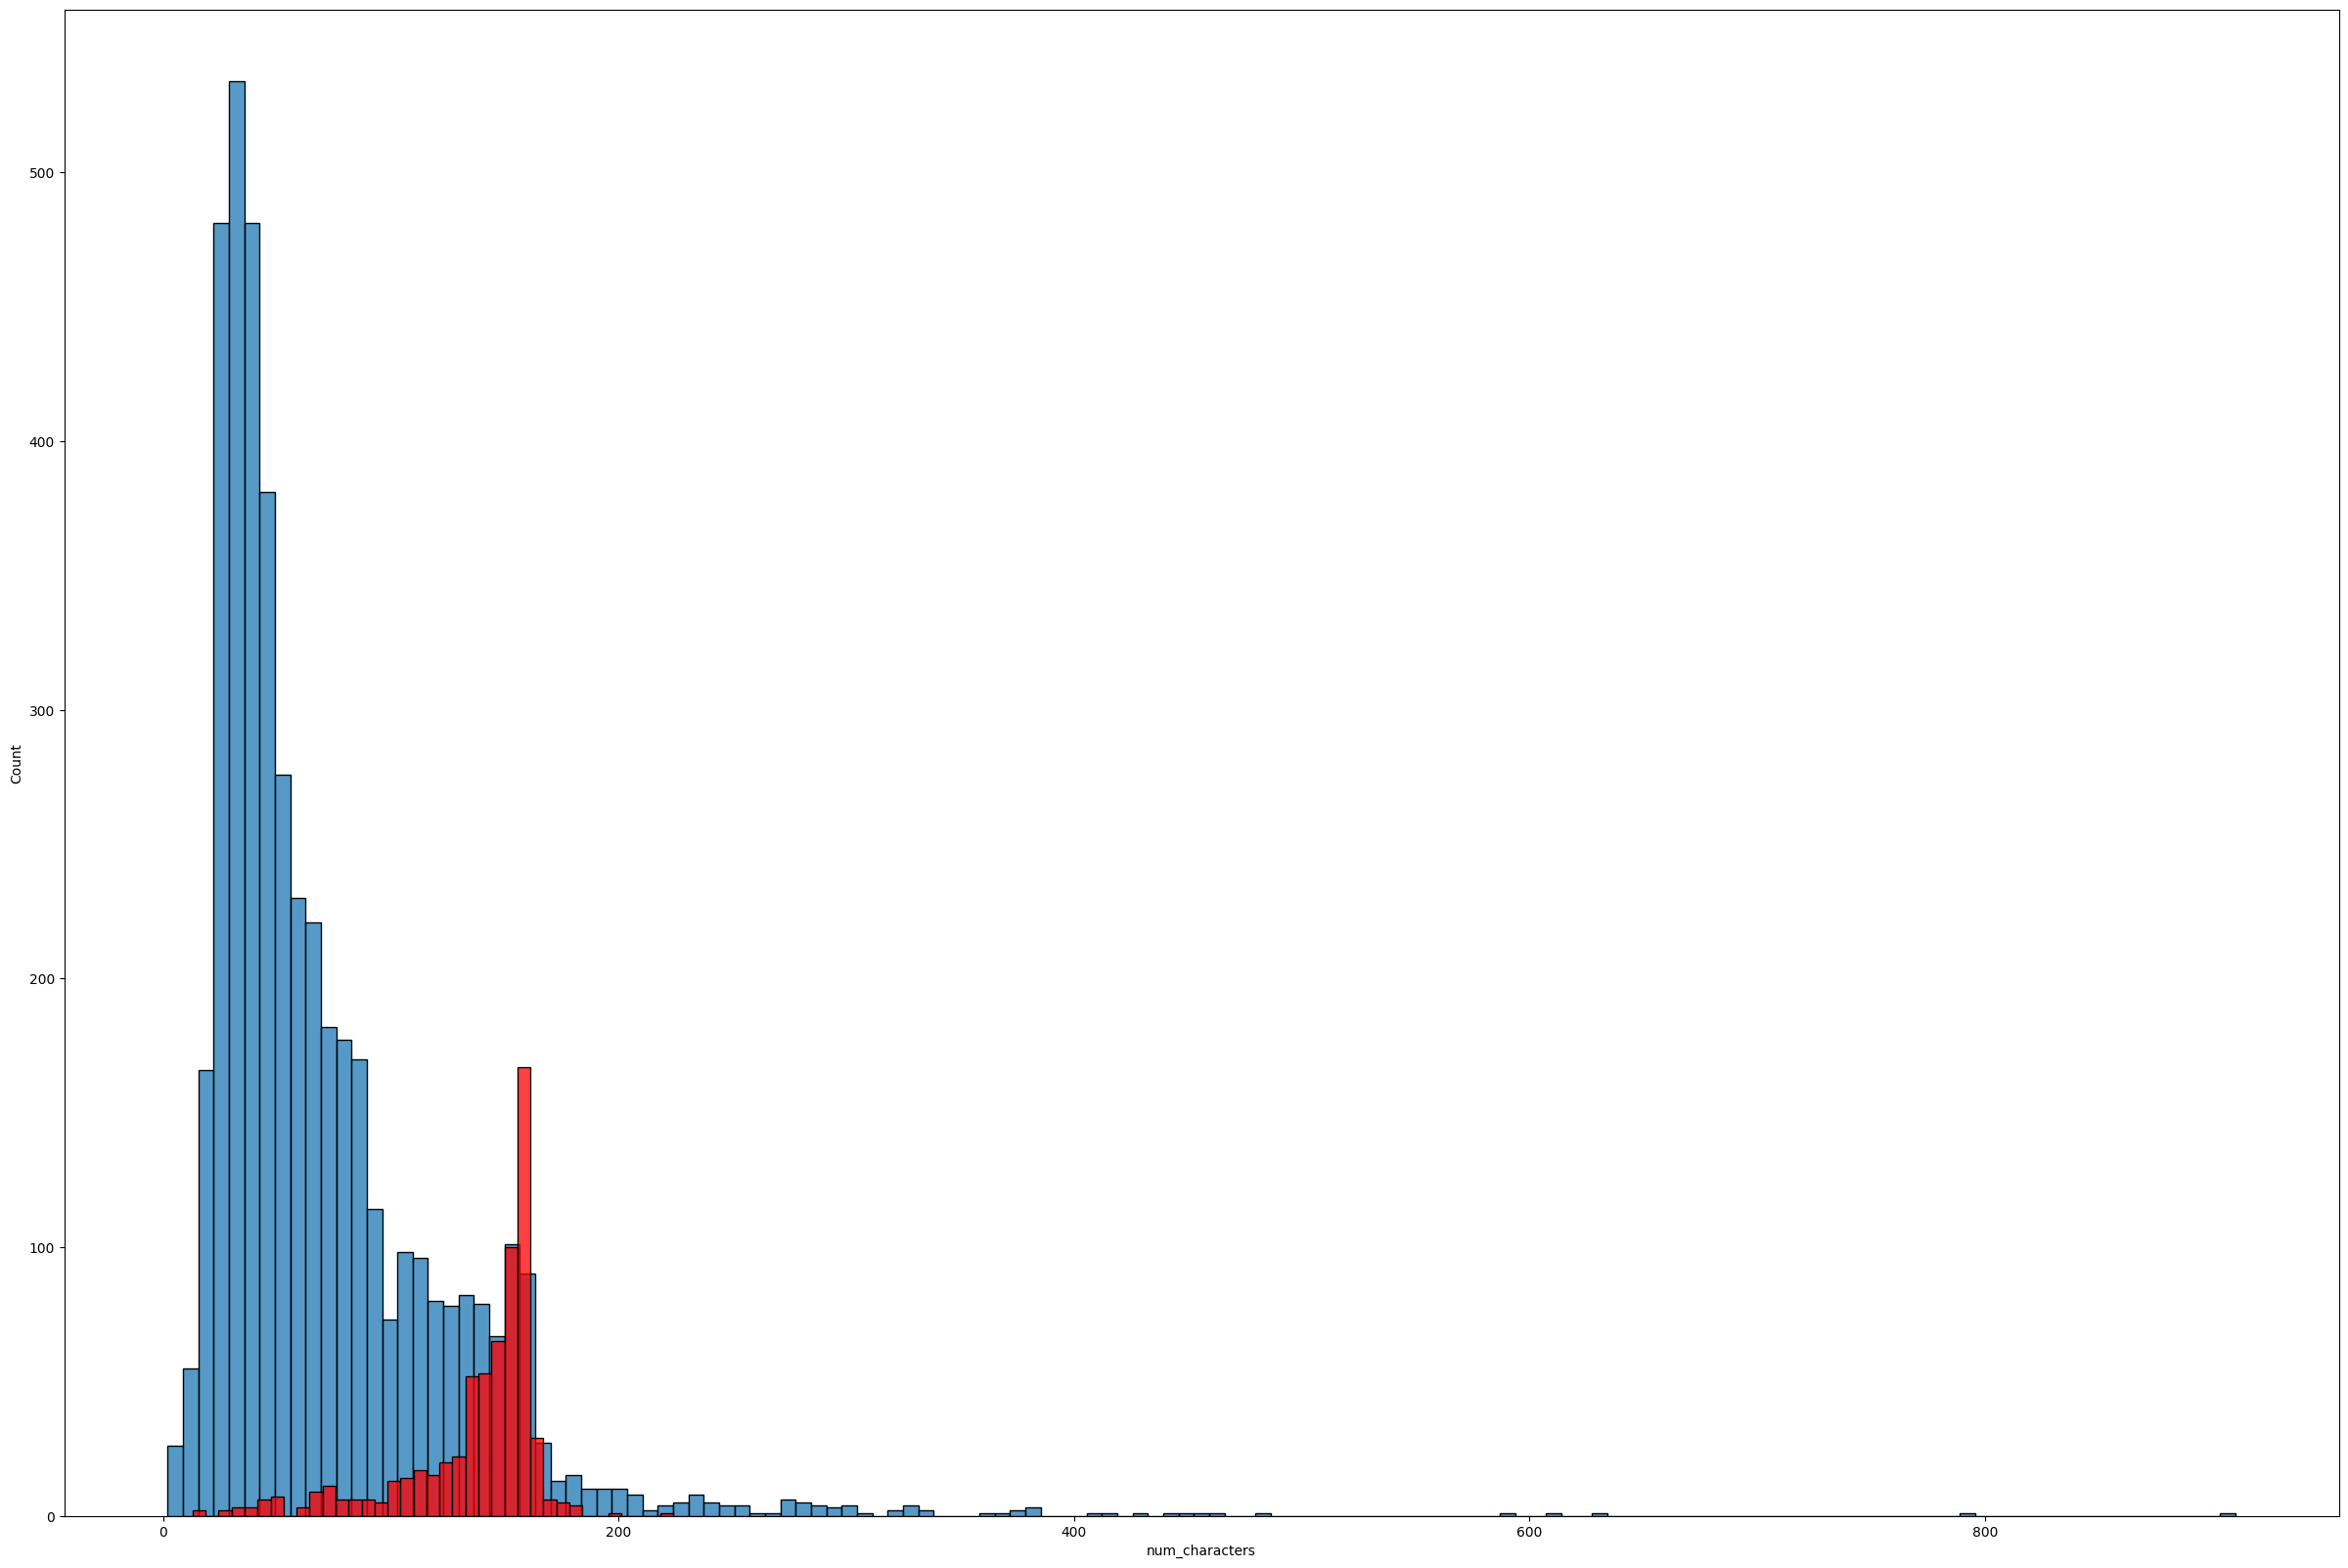

In [34]:
plt.figure(figsize = (30,20))
sns.histplot(df[df['label'] == 0]['num_characters'])
sns.histplot(df[df['label'] == 1]['num_characters'],color='red')

<div style="border:2px solid yellow; padding:10px; background-color:#ffffcc; border-radius:8px; color:black;">

* The histogram shows that spam messages generally contain fewer characters compared to ham messages.

<Axes: xlabel='num_words', ylabel='Count'>

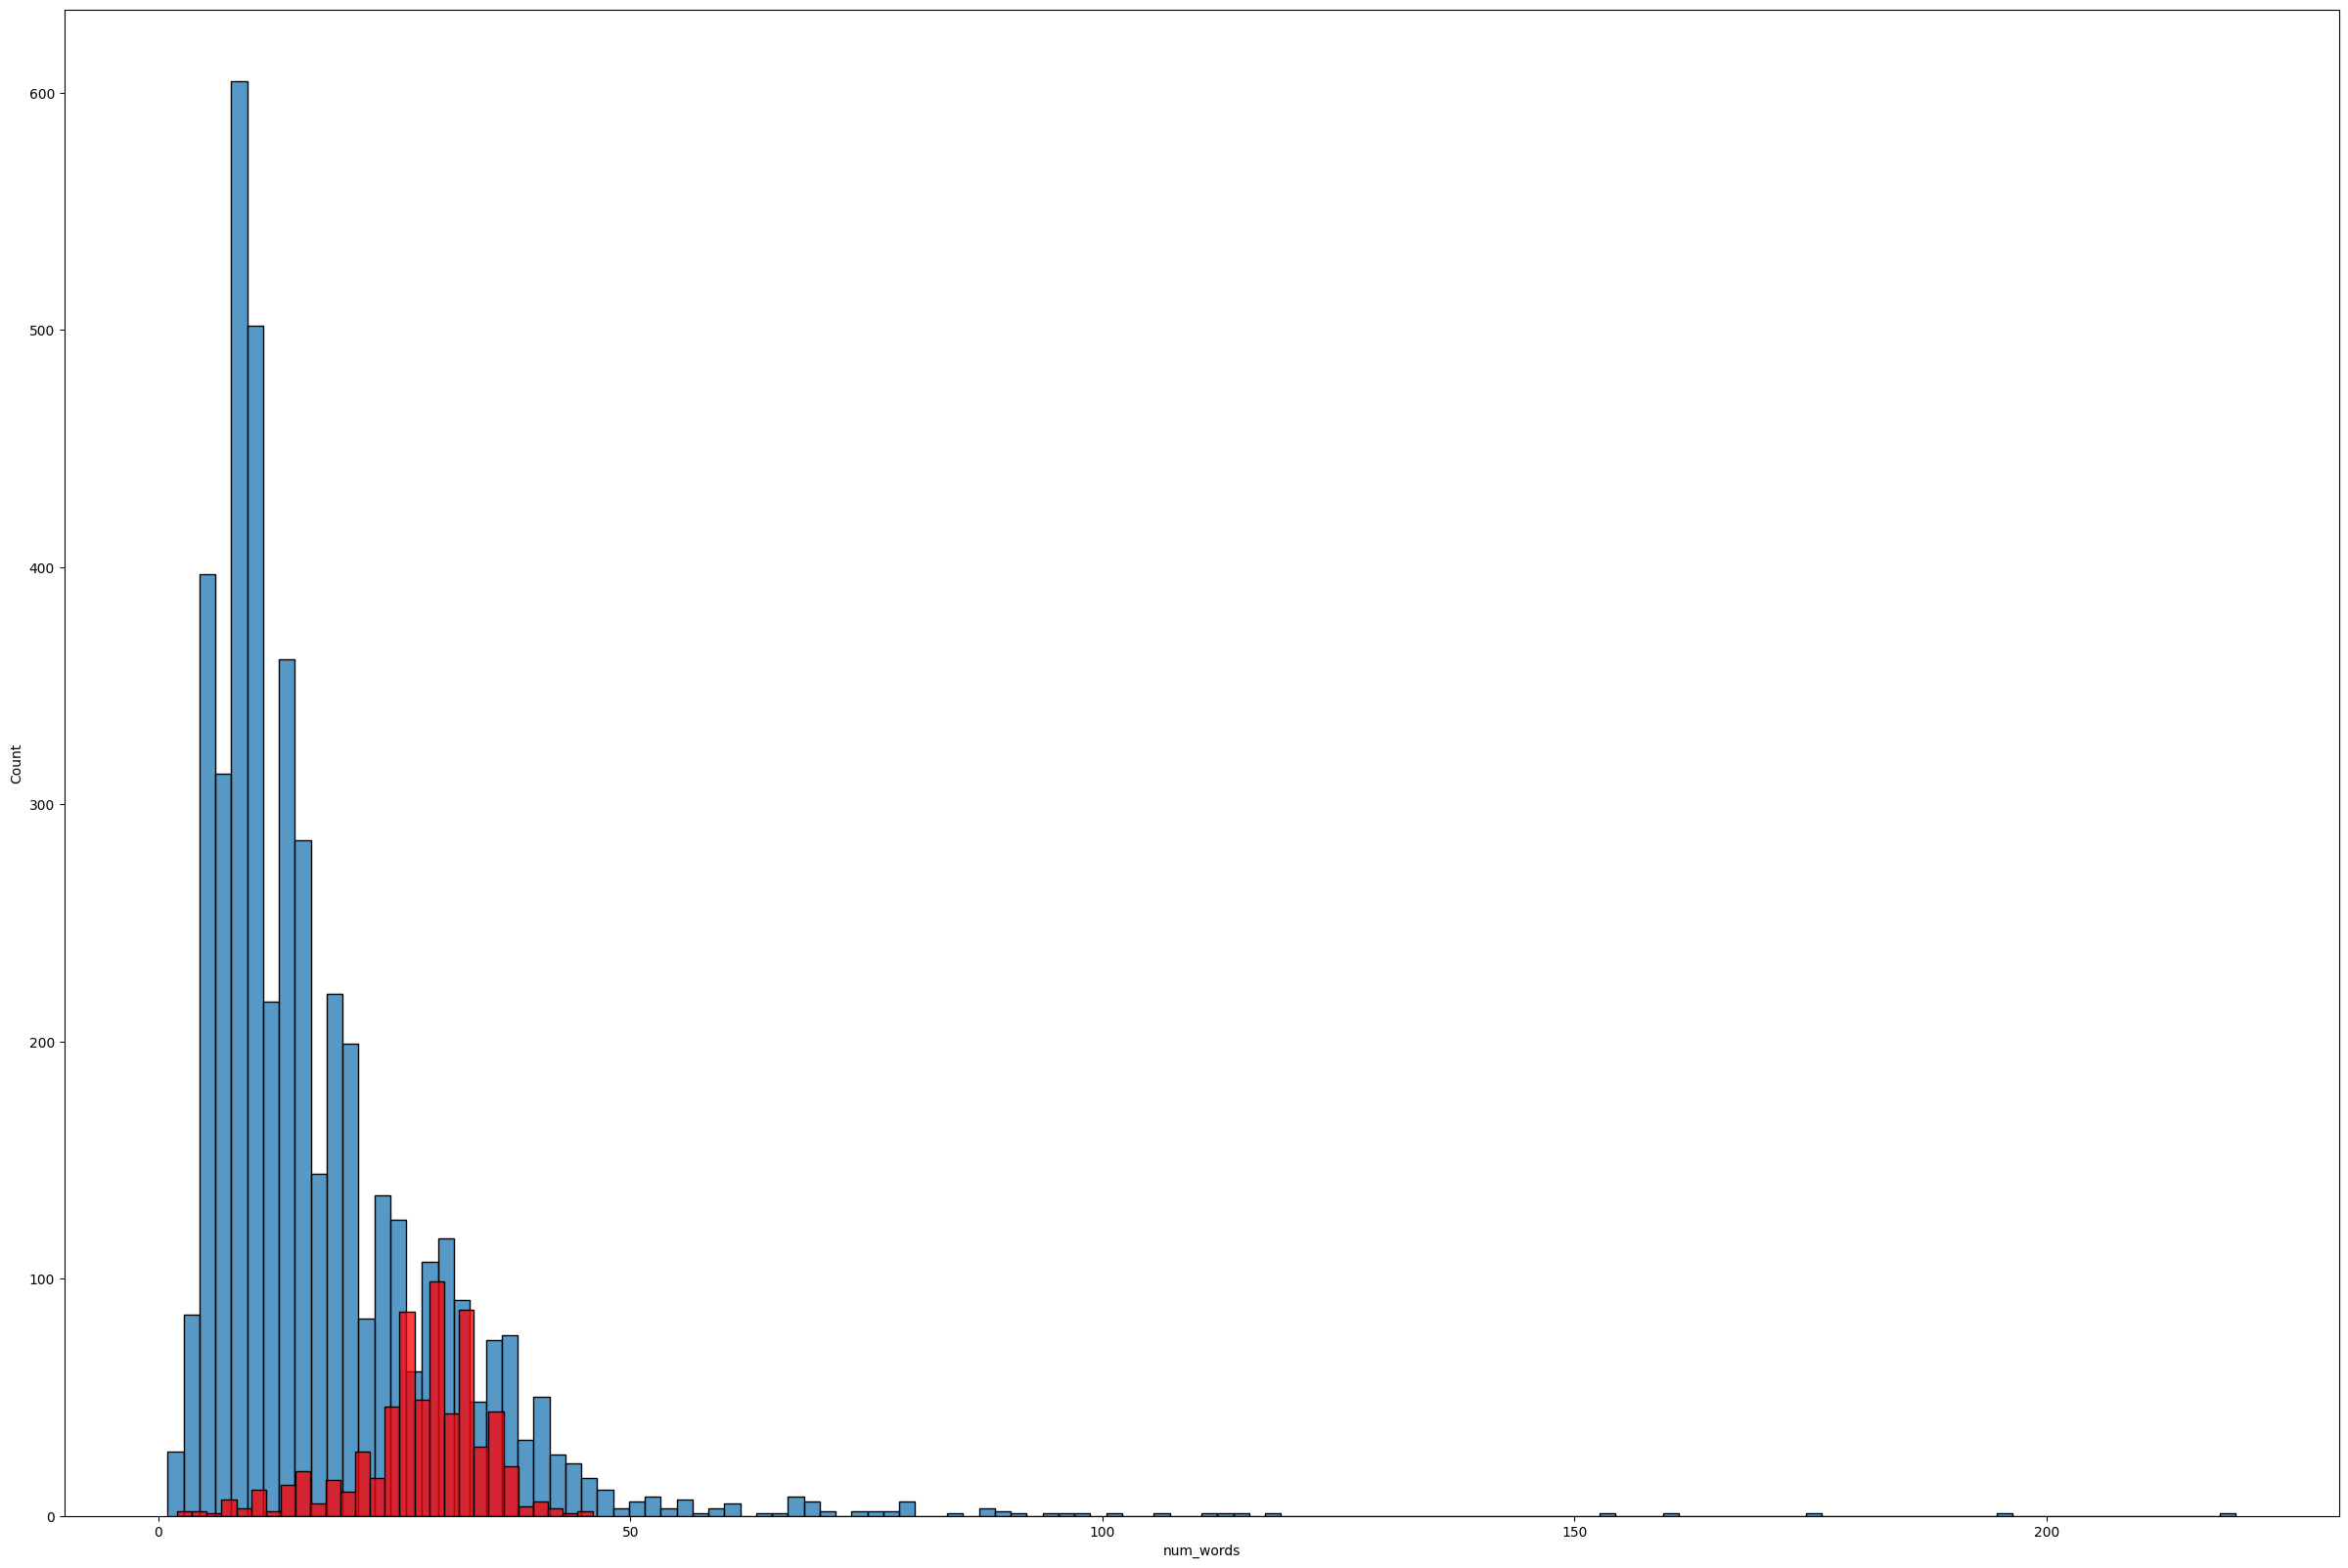

In [35]:
plt.figure(figsize = (30,20))
sns.histplot(df[df['label'] == 0]['num_words'])
sns.histplot(df[df['label'] == 1]['num_words'],color='red')

<div style="border:2px solid yellow; padding:10px; background-color:#ffffcc; border-radius:8px; color:black;">

* The histogram shows that spam messages generally contain fewer words compared to ham messages.

<div style="border:2px solid yellow; padding:10px; background-color:#ffffcc; border-radius:8px; color:black;">

### **Pairplot Visualization**

To see relationships between features (num_characters, num_words, num_sentences) across labels:

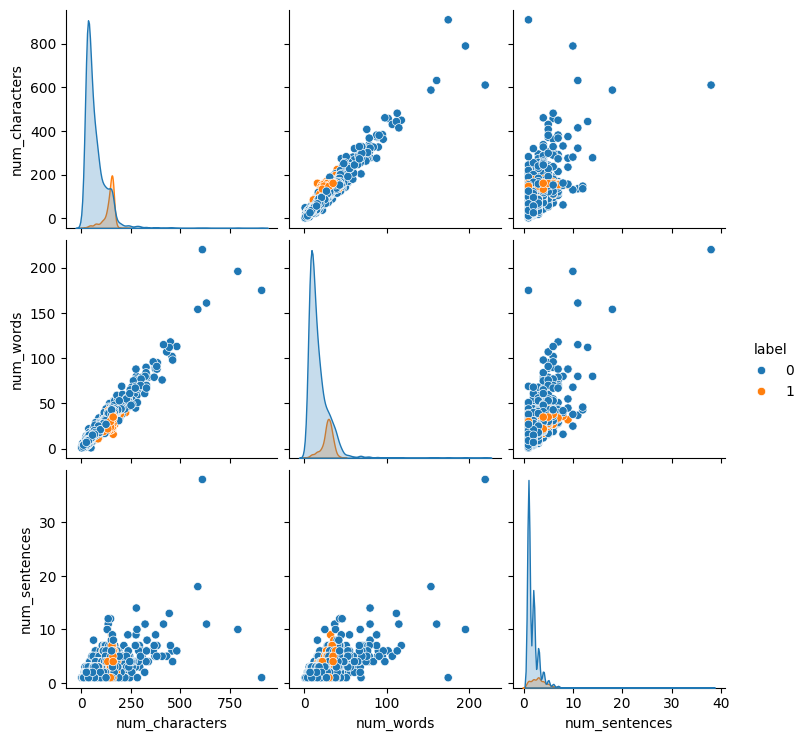

In [36]:
sns.pairplot(df, hue='label')

<div style="border:2px solid yellow; padding:10px; background-color:#ffffcc; border-radius:8px; color:black;">

### **Pair Plot Summary**

1. **num_characters vs num_characters** — Ham messages vary widely in length, while spam messages are more concentrated.  
2. **num_words vs num_characters** — Longer messages in characters usually have more words, with ham showing more spread.  
3. **num_sentences vs num_characters** — Longer character counts generally correspond to more sentences, especially in ham.  
4. **num_characters vs num_words** — More words almost always mean more characters, with ham having greater variation.  
5. **num_words vs num_words** — Ham has a broader spread of word counts, while spam is clustered in fewer counts.  
6. **num_sentences vs num_words** — Messages with more words tend to have more sentences, with ham showing more variability.  
7. **num_characters vs num_sentences** — Longer messages in characters typically have more sentences, especially in ham.  
8. **num_words vs num_sentences** — More words generally mean more sentences, but ham shows a wider range.  
9. **num_sentences vs num_sentences** — Spam usually has fewer sentences than ham, which spans a wider range.



<div style="border:2px solid yellow; padding:10px; background-color:#ffffcc; border-radius:8px; color:black;">

### **Correlation Analysis**

Finally, I plotted a correlation heatmap to examine relationships between features:

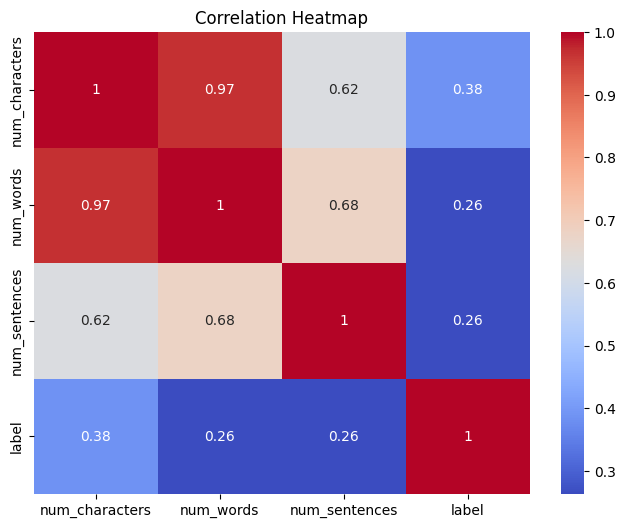

In [37]:
plt.figure(figsize=(8,6))
sns.heatmap(df[['num_characters', 'num_words', 'num_sentences', 'label']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


<div style="border:2px solid yellow; padding:10px; background-color:#ffffcc; border-radius:8px; color:black;">

The correlation analysis reveals that num_characters and num_words are highly correlated (0.97), indicating that longer messages in characters almost always contain more words. Both num_characters and num_words show moderate correlation with num_sentences (0.62 and 0.68 respectively), reflecting that longer messages tend to include more sentences. Correlation with the label is generally weak (0.26–0.38), suggesting that while spam messages are slightly longer and contain more words/sentences than ham messages, these features alone are not strong predictors of spam. 

<div style="border:2px solid pink; padding:10px; background-color:#ffccff; border-radius:8px; color:black;">

##  **Data Preprocessing**  

Text data is unstructured and needs to be cleaned before feeding into a machine learning model.  
I designed a **custom preprocessing pipeline** using **NLTK** for the following tasks:  


<div style="border:2px solid pink; padding:10px; background-color:#ffccff; border-radius:8px; color:black;">

#### **Lowercasing**
Convert all text to lowercase to maintain uniformity (e.g., *"FREE"* and *"free"* should be treated the same).  


In [38]:
# Lower Case

def lower_text(text):
    text = text.lower()
    return text 

<div style="border:2px solid pink; padding:10px; background-color:#ffccff; border-radius:8px; color:black;">

### **Tokenization**

Split the text into individual words (tokens).

In [39]:
def tokennize_text(text):
    text = nltk.word_tokenize(text)
    return text

<div style="border:2px solid pink; padding:10px; background-color:#ffccff; border-radius:8px; color:black;"> 

### **Removing Special Characters**

Keep only alphanumeric tokens and discard special characters.

In [40]:
def remove_spec_char(text):
    y = []
    for txt in text:
        if txt.isalnum():
            y.append(txt)
    return y

<div style="border:2px solid pink; padding:10px; background-color:#ffccff; border-radius:8px; color:black;">

### **Removing Stopwords and Punctuation**

Eliminate commonly used words (like the, is, and) and punctuation that do not contribute to meaning.

In [41]:
from nltk.corpus import stopwords
import string

def remove_stop_pun(text):
    y = []
    for txt in text:
        if txt not in stopwords.words('english') and txt not in string.punctuation:
            y.append(txt)

    return y

<div style="border:2px solid pink; padding:10px; background-color:#ffccff; border-radius:8px; color:black;">

### **Stemming**

Convert words to their root form (e.g., running → run, loved → love) using PorterStemmer.

In [42]:
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

def stemming(text):
    y =[]
    for txt in text:
        y.append(ps.stem(txt))

    return " ".join(y)


<div style="border:2px solid pink; padding:10px; background-color:#ffccff; border-radius:8px; color:black;">

### **Building the Preprocessing Pipeline**

I combined all the above steps into a single pipeline, making the process reusable and modular.

In [43]:
pipeline = [
    lower_text,
    tokennize_text,
    remove_spec_char,
    remove_stop_pun,
    stemming
]

# Function to run all steps
def preprocess_text(text):
    for func in pipeline:
        text = func(text)
    return text

<div style="border:2px solid pink; padding:10px; background-color:#ffccff; border-radius:8px; color:black;">

### **Applying Preprocessing**

Finally, I created a new column transformed_text containing the cleaned SMS messages.

In [44]:
df['transformed_text'] = df['text'].apply(preprocess_text)

In [45]:
df.head()

,label,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


<div style="border:2px solid saddlebrown; padding:10px; background-color:#f4e1d2; border-radius:8px; color:black;">
    


### **Text Visualization and Word Frequency Analysis**

After preprocessing, I explored the most frequent words in **spam** and **ham** messages to gain insights into their vocabulary.  


In [46]:
#!pip install wordcloud

<div style="border:2px solid saddlebrown; padding:10px; background-color:#f4e1d2; border-radius:8px; color:black;">


### **WordCloud Visualization**
WordClouds are useful to visualize the most common words, where word size indicates frequency.  

- **Spam WordCloud** → shows typical spam-related terms (e.g., *free, win, call*).  
- **Ham WordCloud** → shows everyday conversational terms.

In [47]:
from wordcloud import WordCloud
wc = WordCloud(width=1000, height = 800, min_font_size = 10, background_color = 'black')

<div style="border:2px solid saddlebrown; padding:10px; background-color:#f4e1d2; border-radius:8px; color:black;">

### **Spam WordCloud**

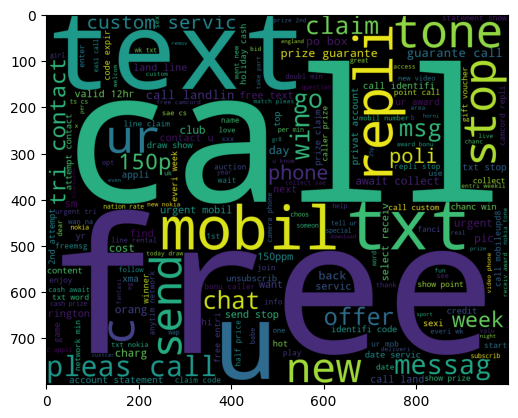

In [48]:
spam_wc = wc.generate(df[df['label'] == 1]['transformed_text'].str.cat(sep= " "))
plt.imshow(spam_wc)

<div style="border:2px solid saddlebrown; padding:10px; background-color:#f4e1d2; border-radius:8px; color:black;">

### **Ham WordCloud**

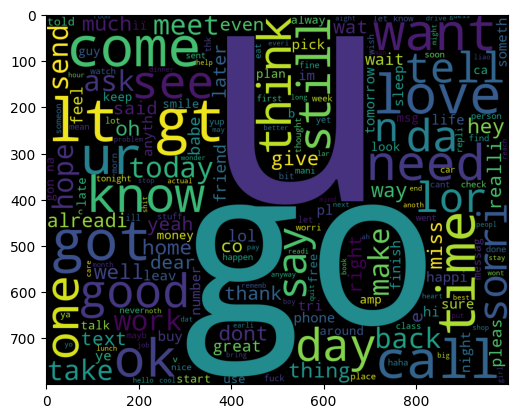

In [49]:
ham_wc = wc.generate(df[df['label'] == 0]['transformed_text'].str.cat(sep= " "))
plt.imshow(ham_wc)

<div style="border:2px solid saddlebrown; padding:10px; background-color:#f4e1d2; border-radius:8px; color:black;">

### **Most Common Words in Spam Messages**

To identify frequently used spam words, I created a corpus of all spam messages and used Counter to extract the top 30 most common words.

In [50]:
spam_corpus = []
for txt in df[df['label'] == 1]['transformed_text'].tolist():
    for word in txt.split():
        spam_corpus.append(word)


In [51]:
len(spam_corpus)

9939

In [52]:
from collections import Counter
Counter(spam_corpus).most_common(30)

[('call', 320),
 ('free', 191),
 ('2', 155),
 ('txt', 141),
 ('text', 122),
 ('u', 119),
 ('ur', 119),
 ('mobil', 114),
 ('stop', 104),
 ('repli', 103),
 ('claim', 98),
 ('4', 97),
 ('prize', 82),
 ('get', 74),
 ('new', 64),
 ('servic', 64),
 ('tone', 63),
 ('send', 60),
 ('urgent', 57),
 ('nokia', 57),
 ('contact', 56),
 ('award', 55),
 ('phone', 52),
 ('cash', 51),
 ('pleas', 51),
 ('week', 49),
 ('win', 48),
 ('c', 45),
 ('collect', 45),
 ('min', 45)]

In [53]:
most_common_spam = pd.DataFrame(Counter(spam_corpus).most_common(30),columns= ['Word', 'Count'])
most_common_spam

,Word,Count
0,call,320
1,free,191
2,2,155
3,txt,141
4,text,122
5,u,119
6,ur,119
7,mobil,114
8,stop,104
9,repli,103


<div style="border:2px solid saddlebrown; padding:10px; background-color:#f4e1d2; border-radius:8px; color:black;">

* I then plotted the top 30 spam words using a barplot.

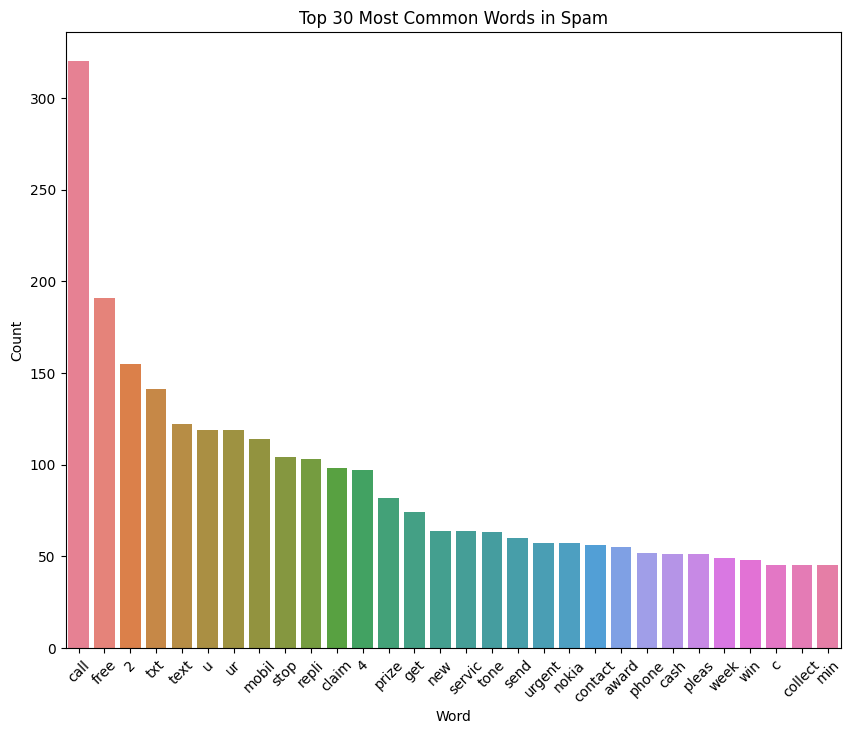

In [54]:
palette = sns.color_palette("husl", 30)  

plt.figure(figsize=(10,8))
sns.barplot(x='Word', y='Count', data=most_common_spam,hue='Word',palette=palette, legend=False)
plt.xticks(rotation=45)
plt.title("Top 30 Most Common Words in Spam")
plt.show()

<div style="border:2px solid saddlebrown; padding:10px; background-color:#f4e1d2; border-radius:8px; color:black;">

### **Most Common Words in Ham Messages**

Similarly, I analyzed the ham corpus to find the top 30 most common words in non-spam messages.

In [55]:
ham_corpus = []
for txt in df[df['label'] == 0]['transformed_text'].tolist():
    for word in txt.split():
        ham_corpus.append(word)

len(ham_corpus)

35404

In [56]:
most_common_ham = pd.DataFrame(Counter(ham_corpus).most_common(30),columns= ['Word', 'Count'])
most_common_ham

,Word,Count
0,u,883
1,go,404
2,get,349
3,gt,288
4,lt,287
5,2,284
6,come,275
7,got,236
8,know,236
9,like,234


<div style="border:2px solid saddlebrown; padding:10px; background-color:#f4e1d2; border-radius:8px; color:black;">

* Barplot Visualization for ham words

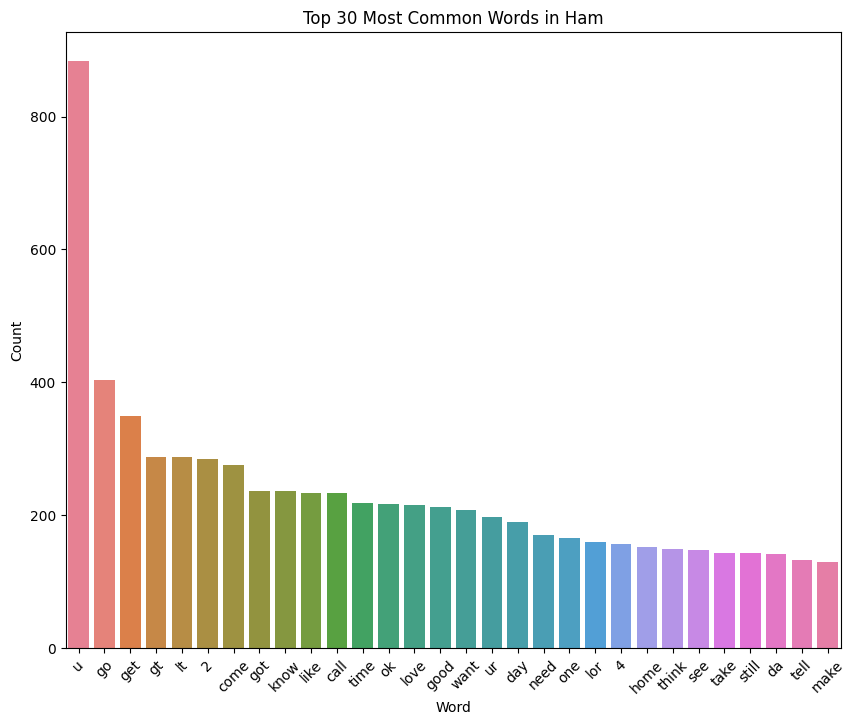

In [57]:
palette = sns.color_palette("husl", 30)  

plt.figure(figsize=(10,8))
sns.barplot(x='Word', y='Count', data=most_common_ham,hue='Word',palette=palette, legend=False)
plt.xticks(rotation=45)
plt.title("Top 30 Most Common Words in Ham")
plt.show()

<div style="border:2px solid darkorange; padding:10px; background-color:#ffe5cc; border-radius:8px; color:black;">
    
## **Feature Extraction using TF-IDF**

To convert the cleaned text into numerical features suitable for machine learning, I used **TF-IDF (Term Frequency – Inverse Document Frequency)**.  
- **TF** measures how often a word appears in a document.  
- **IDF** reduces the importance of commonly used words across all documents.  

I limited the features to the **top 3000 words** to reduce dimensionality.  


In [58]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
tfidf = TfidfVectorizer(max_features=3000)

In [59]:
X = tfidf.fit_transform(df['transformed_text']).toarray()

In [60]:
X.shape

(5169, 3000)

In [61]:
y = df['label'].values

<div style="border:2px solid darkorange; padding:10px; background-color:#ffe5cc; border-radius:8px; color:black;">

#### **Train-Test Split**

I split the dataset into 80% training and 20% testing sets for model evaluation.

In [62]:
from sklearn.model_selection import train_test_split

In [63]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=2)

<div style="border:2px solid darkorange; padding:10px; background-color:#ffe5cc; border-radius:8px; color:black;">

### **Model Building with Naive Bayes**

I experimented with three types of Naive Bayes classifiers:

1. GaussianNB → assumes features follow a Gaussian distribution.

2. MultinomialNB → works well with word counts/TF-IDF values (best suited for text classification).

3. BernoulliNB → works with binary features (word present or not).

In [64]:
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score

In [65]:
gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

<div style="border:2px solid darkorange; padding:10px; background-color:#ffe5cc; border-radius:8px; color:black;">

### **Gaussian Naive Bayes**

In [66]:
gnb.fit(X_train,y_train)
y_pred1 = gnb.predict(X_test)
print("Gaussian Naive Bayes Results")
print("-" * 40)
print(f"Accuracy  : {accuracy_score(y_test, y_pred1):.4f}")
print(f"Precision : {precision_score(y_test, y_pred1):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred1))
print("\n")

Gaussian Naive Bayes Results
----------------------------------------
Accuracy  : 0.8733
Precision : 0.5160
Confusion Matrix:
[[790 106]
 [ 25 113]]




<div style="border:2px solid darkorange; padding:10px; background-color:#ffe5cc; border-radius:8px; color:black;">

### **Multinomial Naive Bayes**

In [67]:
mnb.fit(X_train,y_train)
y_pred2 = mnb.predict(X_test)

print("Multinomial Naive Bayes Results")
print("-" * 40)
print(f"Accuracy  : {accuracy_score(y_test, y_pred2):.4f}")
print(f"Precision : {precision_score(y_test, y_pred2):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred2))
print("\n")

Multinomial Naive Bayes Results
----------------------------------------
Accuracy  : 0.9710
Precision : 1.0000
Confusion Matrix:
[[896   0]
 [ 30 108]]




<div style="border:2px solid darkorange; padding:10px; background-color:#ffe5cc; border-radius:8px; color:black;">

### **Bernoulli Naive Bayes**

In [68]:
bnb.fit(X_train,y_train)
y_pred3 = bnb.predict(X_test)

print("Bernoulli Naive Bayes Results")
print("-" * 40)
print(f"Accuracy  : {accuracy_score(y_test, y_pred3):.4f}")
print(f"Precision : {precision_score(y_test, y_pred3):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred3))

Bernoulli Naive Bayes Results
----------------------------------------
Accuracy  : 0.9836
Precision : 0.9919
Confusion Matrix:
[[895   1]
 [ 16 122]]


<div style="border:2px solid darkorange; padding:10px; background-color:#ffe5cc; border-radius:8px; color:black;">

## **Overall Model Performance Summary**

After experimenting with **Gaussian Naive Bayes, Multinomial Naive Bayes, and Bernoulli Naive Bayes**, we compared their performance on the spam classification dataset.

* **Gaussian Naive Bayes** achieved a moderate accuracy (87.3%) but relatively low precision (51.6%), indicating it struggles with false positives.
* **Multinomial Naive Bayes** performed significantly better with **97.1% accuracy** and **perfect precision (100%)**, showing strong performance in identifying spam correctly without false alarms.
* **Bernoulli Naive Bayes** achieved the **best overall performance** with **98.3% accuracy** and **99.2% precision**, making it the most reliable model for this task.

### 🔹 Performance Comparison Table

| Model                   | Accuracy | Precision |
| ----------------------- | -------- | --------- |
| Gaussian Naive Bayes    | 87.33%   | 51.60%    |
| Multinomial Naive Bayes | 97.10%   | 100.00%   |
| Bernoulli Naive Bayes   | 98.36%   | 99.19%    |




<div style="border:2px solid indigo; padding:10px; background-color:#e6ccff; border-radius:8px; color:black;">
    
### **Importing Models**

After evaluating Naive Bayes models, I expanded the analysis by testing a variety of machine learning algorithms to compare their effectiveness on spam classification.

I imported several classification algorithms from Scikit-Learn and XGBoost.

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

<div style="border:2px solid indigo; padding:10px; background-color:#e6ccff; border-radius:8px; color:black;">
    
### **Defining Classifiers**

Each classifier was initialized with basic hyperparameters for a fair comparison.

In [70]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [71]:
clfs = {
    'SVC' : svc,
    'KN' : knc, 
    'NB': mnb, 
    'DT': dtc, 
    'LR': lrc, 
    'RF': rfc, 
    'AdaBoost': abc, 
    'BgC': bc, 
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb
}

<div style="border:2px solid indigo; padding:10px; background-color:#e6ccff; border-radius:8px; color:black;">

### **Training & Evaluation Function**

A reusable function train_classifier() was defined to:

1. Fit the model on training data.

2. Make predictions on the test data.

3. Compute Accuracy and Precision.

In [72]:
def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    
    return accuracy,precision

<div style="border:2px solid indigo; padding:10px; background-color:#e6ccff; border-radius:8px; color:black;">

### **Running All Models**

Each model in clfs was trained and evaluated using the above function. Results were printed for accuracy and precision.

In [74]:
accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():
    
    current_accuracy,current_precision = train_classifier(clf, X_train,y_train,X_test,y_test)
    
    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    
    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  SVC
Accuracy -  0.9758220502901354
Precision -  0.9747899159663865
For  KN
Accuracy -  0.9052224371373307
Precision -  1.0
For  NB
Accuracy -  0.9709864603481625
Precision -  1.0
For  DT
Accuracy -  0.9303675048355899
Precision -  0.8367346938775511
For  LR
Accuracy -  0.9564796905222437
Precision -  0.9696969696969697
For  RF
Accuracy -  0.97678916827853
Precision -  0.975
For  AdaBoost
Accuracy -  0.9235976789168279
Precision -  0.8390804597701149
For  BgC
Accuracy -  0.9593810444874274
Precision -  0.8692307692307693
For  ETC
Accuracy -  0.9777562862669246
Precision -  0.967479674796748
For  GBDT
Accuracy -  0.9506769825918762
Precision -  0.9306930693069307
For  xgb
Accuracy -  0.9709864603481625
Precision -  0.95


In [75]:
performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)

In [76]:
performance_df

,Algorithm,Accuracy,Precision
1,KN,0.905222,1.000000
2,NB,0.970986,1.000000
5,RF,0.976789,0.975000
0,SVC,0.975822,0.974790
4,LR,0.956480,0.969697
8,ETC,0.977756,0.967480
10,xgb,0.970986,0.950000
9,GBDT,0.950677,0.930693
7,BgC,0.959381,0.869231
6,AdaBoost,0.923598,0.839080


<div style="border:2px solid indigo; padding:10px; background-color:#e6ccff; border-radius:8px; color:black;">

### **Final Summary**

In this project, I compared multiple machine learning models to detect spam messages. The results clearly show that some algorithms perform much better than others in terms of both accuracy and precision.

Among all models, **K-Nearest Neighbors (KNN)** and **Multinomial Naive Bayes (NB)** achieved perfect precision (1.0). This means they were able to identify spam messages without wrongly classifying any normal (ham) messages as spam. However, KNN had a lower overall accuracy compared to NB.

On the other hand, ensemble methods such as **Random Forest (RF)** and **Extra Trees Classifier (ETC)** achieved the highest accuracy (around 97.7%) while also maintaining strong precision above 0.96. Similarly, **Support Vector Classifier (SVC)** and **Logistic Regression (LR)** gave very balanced results with accuracy and precision both close to 95% or higher.

Models like **Decision Tree** and **AdaBoost** did not perform as well, with precision below 0.85, making them less reliable for spam classification.

Overall, the study shows that while Naive Bayes and KNN are excellent for avoiding false positives, ensemble models like RF and ETC provide the best balance of accuracy and reliability, making them more suitable for practical use.
